In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 라이브러리 불러오기

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

In [2]:
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 데이터 불러오기

In [3]:
df = pd.read_csv('/content/drive/MyDrive/테킷/13.데이터톤-19/data/최종합본_final.csv')

df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['총구매금액'], axis=1, inplace=True)   # 다시 계산해서 생성할 예정
df.head(2)

,주문 고유 ID,고객 ID,주문 상태,구매 시간,물류 처리 시간,실제 배송 날짜,기대 배송 날짜,고객 고유 ID,우편번호 앞부분,도시,...,리뷰 답변 시간,카테고리 이름,제품 무게(g),제품 길이(cm),제품 높이(cm),제품 너비(cm),상위 카테고리,판매자 우편번호 앞자리,판매자 도시(city),판매자 주(state)
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,CUSTOMER_Unique_60785,3149,sao paulo,...,2018-10-12,home_utilities,500.0,19.0,8.0,13.0,home,9350.0,maua,SP
1,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,CUSTOMER_Unique_60785,3149,sao paulo,...,2018-10-12,home_utilities,500.0,19.0,8.0,13.0,home,9350.0,maua,SP


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105767 entries, 0 to 105766
Data columns (total 37 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   주문 고유 ID      105767 non-null  object 
 1   고객 ID         105767 non-null  object 
 2   주문 상태         105767 non-null  object 
 3   구매 시간         105767 non-null  object 
 4   물류 처리 시간      105767 non-null  object 
 5   실제 배송 날짜      105767 non-null  object 
 6   기대 배송 날짜      105767 non-null  object 
 7   고객 고유 ID      105767 non-null  object 
 8   우편번호 앞부분      105767 non-null  int64  
 9   도시            105767 non-null  object 
 10  주             105767 non-null  object 
 11  주 한국명         105444 non-null  object 
 12  지역            105444 non-null  object 
 13  고객 위도         105444 non-null  float64
 14  고객 경도         105444 non-null  float64
 15  주문 품목 수       105766 non-null  float64
 16  제품 고유 ID      105766 non-null  object 
 17  판매자 고유 ID     105766 non-null  object 
 18  판매 가

# 데이터 전처리

In [5]:
# 날짜 타입 변경
df['구매 시간']      = pd.to_datetime(df['구매 시간']).astype('datetime64[ns]')
df['물류 처리 시간'] = pd.to_datetime(df['물류 처리 시간']).astype('datetime64[ns]')
df['실제 배송 날짜'] = pd.to_datetime(df['실제 배송 날짜']).astype('datetime64[ns]')
df['기대 배송 날짜'] = pd.to_datetime(df['기대 배송 날짜']).astype('datetime64[ns]')
df['리뷰 생성 시간'] = pd.to_datetime(df['리뷰 생성 시간']).astype('datetime64[ns]')
df['리뷰 답변 시간'] = pd.to_datetime(df['리뷰 답변 시간']).astype('datetime64[ns]')

In [6]:
# 결측치 확인
df.isnull().sum()

주문 고유 ID          0
고객 ID             0
주문 상태             0
구매 시간             0
물류 처리 시간          0
실제 배송 날짜          0
기대 배송 날짜          0
고객 고유 ID          0
우편번호 앞부분          0
도시                0
주                 0
주 한국명           323
지역              323
고객 위도           323
고객 경도           323
주문 품목 수           1
제품 고유 ID          1
판매자 고유 ID         1
판매 가격             1
품목 화물 가격          1
결제 시퀀스            1
지불 방법             1
할부 횟수             1
거래 금액             1
리뷰 고유 ID        810
리뷰 점수           810
리뷰 생성 시간        810
리뷰 답변 시간        810
카테고리 이름          21
제품 무게(g)         21
제품 길이(cm)        21
제품 높이(cm)        21
제품 너비(cm)        21
상위 카테고리          21
판매자 우편번호 앞자리      1
판매자 도시(city)      1
판매자 주(state)      1
dtype: int64

In [7]:
# 결측치 있는 행 삭제
df.drop(32703, axis=0, inplace=True)

In [8]:
# 총구매금액 계산 (고객별로 거래 금액을 합산) 후 컬럼 추가
df['총구매금액'] = df.groupby('고객 ID')['거래 금액'].transform('sum')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105766 entries, 0 to 105766
Data columns (total 38 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   주문 고유 ID      105766 non-null  object        
 1   고객 ID         105766 non-null  object        
 2   주문 상태         105766 non-null  object        
 3   구매 시간         105766 non-null  datetime64[ns]
 4   물류 처리 시간      105766 non-null  datetime64[ns]
 5   실제 배송 날짜      105766 non-null  datetime64[ns]
 6   기대 배송 날짜      105766 non-null  datetime64[ns]
 7   고객 고유 ID      105766 non-null  object        
 8   우편번호 앞부분      105766 non-null  int64         
 9   도시            105766 non-null  object        
 10  주             105766 non-null  object        
 11  주 한국명         105443 non-null  object        
 12  지역            105443 non-null  object        
 13  고객 위도         105443 non-null  float64       
 14  고객 경도         105443 non-null  float64       
 15  주문 품목 수       105766 n

# R 분석

In [10]:
# Recency 분석을 위한 데이터 추출
df_user = pd.DataFrame(df['고객 고유 ID']).drop_duplicates()
df_max_purchase = df.groupby('고객 고유 ID')['구매 시간'].max().reset_index()
df_max_purchase.rename(columns={'구매 시간': 'maxPurchaseDate'},inplace=True)

# 가장 최근 구매 일자 - 고객번호별 최근 구매일자
df_max_purchase['recency'] = (df_max_purchase['maxPurchaseDate'].max() - df_max_purchase['maxPurchaseDate']).dt.days
recency_df = pd.merge(df_user, df_max_purchase, on='고객 고유 ID')

recency_df.recency.describe()

count    85111.000000
mean       227.969158
std        143.225912
min          0.000000
25%        110.000000
50%        206.000000
75%        331.000000
max        664.000000
Name: recency, dtype: float64

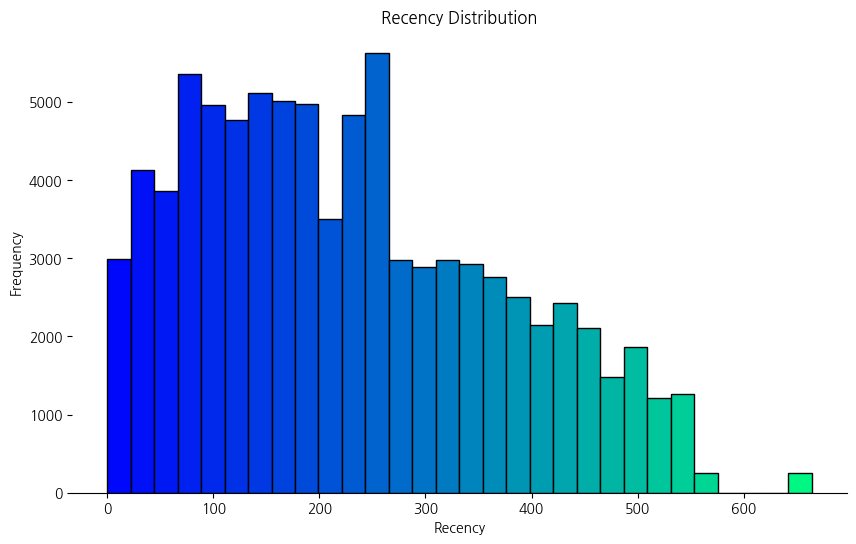

In [13]:
# recency_df 분포 확인
fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(left=True)
n, bins, patches = plt.hist(recency_df['recency'], bins=30, edgecolor='black')

# 'winter' 팔레트를 사용하여 각 막대 색상 설정
palette = sns.color_palette('winter', len(patches))
for color, patch in zip(palette, patches):
    patch.set_facecolor(color)

plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

# F 분석

In [14]:
# Frequency 분석을 위한 데이터 추출
tmp = df[['주문 고유 ID', '고객 고유 ID']].drop_duplicates()
frequency_df = tmp.groupby('고객 고유 ID')['주문 고유 ID'].count().reset_index()

# 고객 고유 아이디로 그룹화 한다음 방문횟수를 구해야 한다.
# 여기서는 방문횟수를 주문 고유 ID 개수로 생각했으므로 주문 고유 ID에 count를 적용한다.
frequency_df = frequency_df.rename(columns={'주문 고유 ID':'Frequency'})
frequency_df.Frequency.describe()

count    85111.000000
mean         1.033403
std          0.207316
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         12.000000
Name: Frequency, dtype: float64

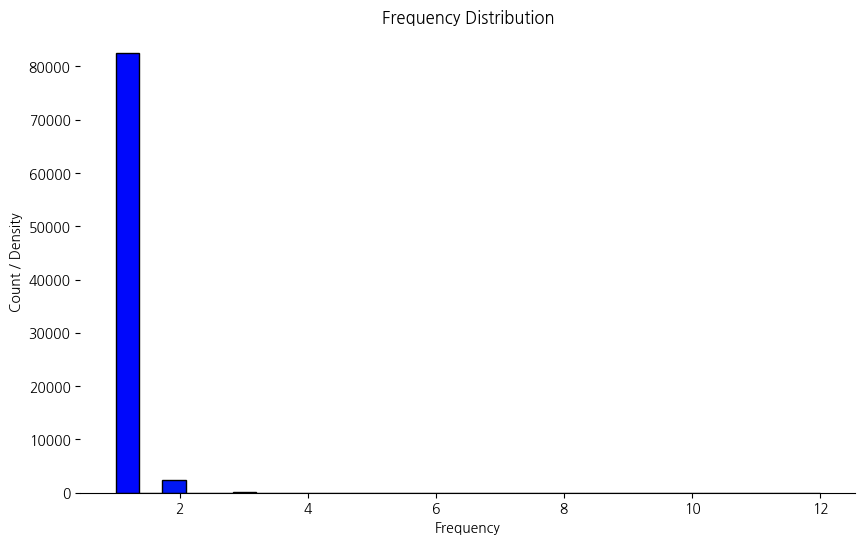

In [15]:
# frequency_df 분포 확인
fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(left=True)
n, bins, patches = plt.hist(frequency_df['Frequency'], bins=30, edgecolor='black')

# 'winter' 팔레트를 사용하여 각 막대 색상 설정
palette = sns.color_palette('winter', len(patches))
for color, patch in zip(palette, patches):
    patch.set_facecolor(color)

plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count / Density')
plt.show()

# M 분석

In [16]:
# Monetary 분석을 위한 데이터 추출
monetary_df = df.groupby('고객 고유 ID')['총구매금액'].sum().reset_index()
monetary_df.rename(columns={'총구매금액' : 'monetary'},inplace=True)
monetary_df.monetary.describe()

count     85111.000000
mean        445.763462
std        6400.628990
min          10.070000
25%          64.620000
50%         116.360000
75%         221.735000
max      905120.000000
Name: monetary, dtype: float64

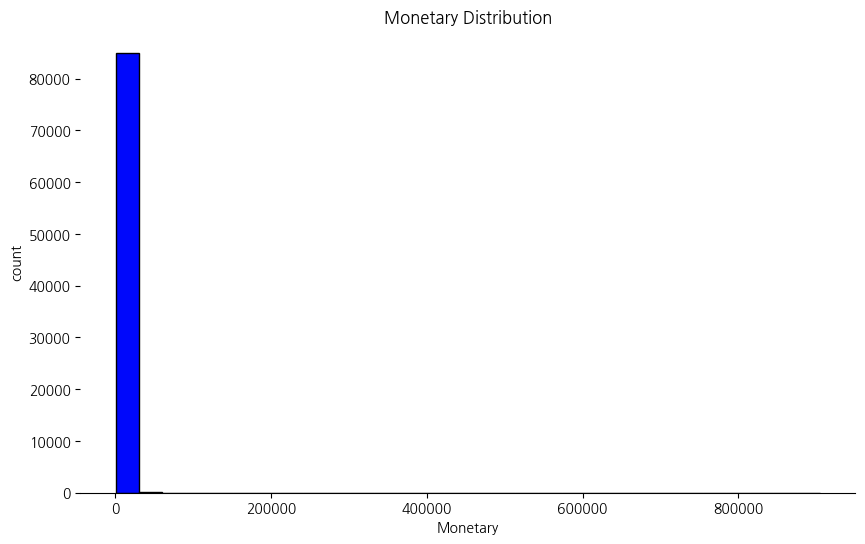

In [18]:
# monetary_df 분포 확인
fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(left=True)
n, bins, patches = plt.hist(monetary_df['monetary'], bins=30, edgecolor='black')

# 'winter' 팔레트를 사용하여 각 막대 색상 설정
palette = sns.color_palette('winter', len(patches))
for color, patch in zip(palette, patches):
    patch.set_facecolor(color)

plt.title('Monetary Distribution')
plt.xlabel('Monetary')
plt.ylabel('count')
plt.show()

# RFM 합친 데이터 프레임 생성

In [19]:
# recency_df, frequency_df, monetary_df 조인해서 csv로 저장하기
rfm = pd.merge(recency_df, frequency_df, on='고객 고유 ID')
rfm = pd.merge(rfm, monetary_df, on='고객 고유 ID')
rfm.to_csv('rfm.csv', index=False)

In [20]:
rfm.head()

,고객 고유 ID,maxPurchaseDate,recency,Frequency,monetary
0,CUSTOMER_Unique_60785,2018-10-02 10:56:33,301,2,160.24
1,CUSTOMER_Unique_52983,2018-11-18 19:28:06,253,1,72.20
2,CUSTOMER_Unique_58227,2019-02-13 21:18:39,166,1,28.62
3,CUSTOMER_Unique_59164,2018-07-09 21:57:05,385,1,175.26
4,CUSTOMER_Unique_74753,2018-05-16 13:10:30,440,1,75.16


# 1회만 구매한 고객에 대한 세분화

In [21]:
rfm_nonrepurchase = rfm[rfm['Frequency'] == 1]
rfm_nonrepurchase=rfm_nonrepurchase[['고객 고유 ID', 'recency','Frequency','monetary']]
rfm_nonrepurchase.shape

(82553, 4)

In [22]:
rfm_nonrepurchase.head()

,고객 고유 ID,recency,Frequency,monetary
1,CUSTOMER_Unique_52983,253,1,72.20
2,CUSTOMER_Unique_58227,166,1,28.62
3,CUSTOMER_Unique_59164,385,1,175.26
4,CUSTOMER_Unique_74753,440,1,75.16
5,CUSTOMER_Unique_31015,552,1,35.95


# R지표 log + minmax

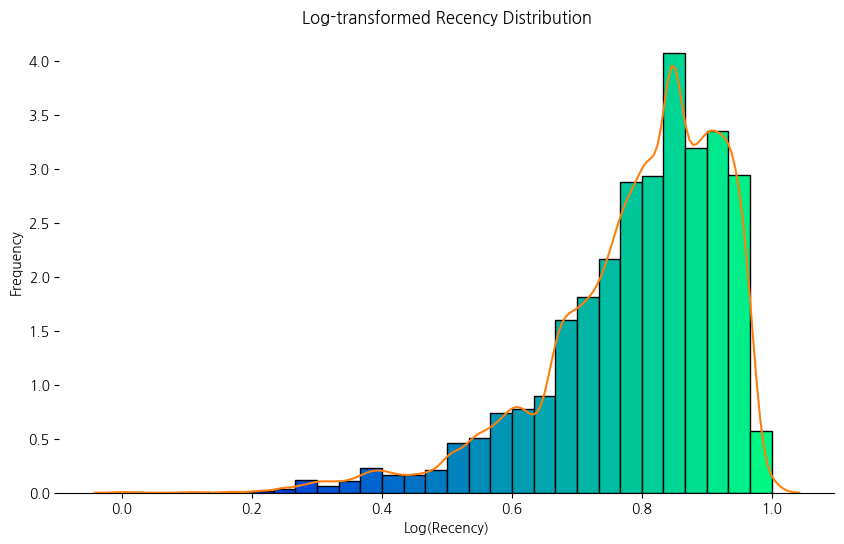

In [27]:
# 로그변환
rfm_nonrepurchase['recency_log'] = np.log1p(rfm_nonrepurchase['recency'])

# MinMax 스케일링
scaler = MinMaxScaler()
rfm_nonrepurchase['recency_log_norm'] = scaler.fit_transform(rfm_nonrepurchase['recency_log'].values.reshape(-1,1))

# 히스토그램 생성
fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(left=True)
n, bins, patches = plt.hist(rfm_nonrepurchase['recency_log_norm'], bins=30, edgecolor='black', density=True)

# 'winter' 팔레트를 사용하여 각 막대 색상 설정
palette = sns.color_palette('winter', len(patches))
for color, patch in zip(palette, patches):
    patch.set_facecolor(color)

# KDE plot 추가
sns.kdeplot(rfm_nonrepurchase['recency_log_norm'], color='blue', ax=ax)

plt.title('Log-transformed Recency Distribution')
plt.xlabel('Log(Recency)')
plt.ylabel('Frequency')
plt.show()

# M지표 log + minmax

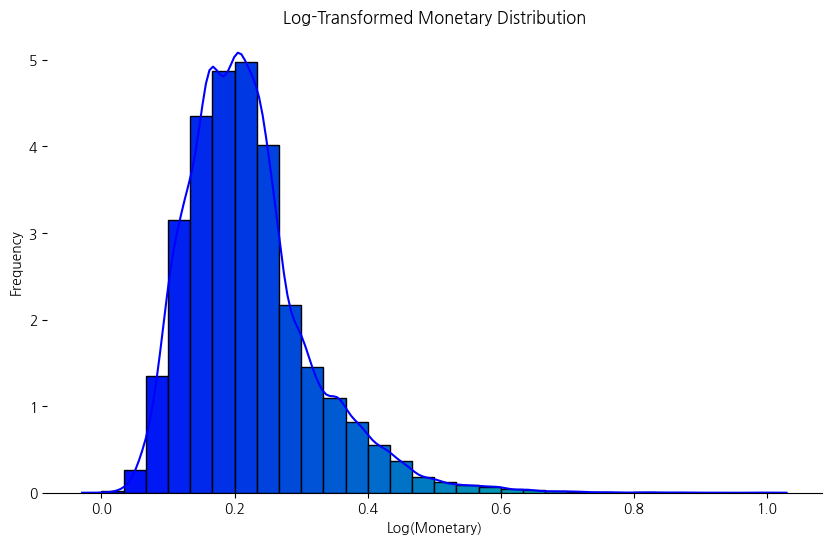

In [26]:
# 로그변환
rfm_nonrepurchase['monetary_log'] = np.log1p(rfm_nonrepurchase['monetary'])

# MinMax 스케일링
rfm_nonrepurchase['monetary_log_norm'] = scaler.fit_transform(rfm_nonrepurchase['monetary_log'].values.reshape(-1,1))

# 히스토그램 생성
fig, ax = plt.subplots(figsize=(10, 6))
sns.despine(left=True)
n, bins, patches = plt.hist(rfm_nonrepurchase['monetary_log_norm'], bins=30, edgecolor='black', density=True)

# 'winter' 팔레트를 사용하여 각 막대 색상 설정
palette = sns.color_palette('winter', len(patches))
for color, patch in zip(palette, patches):
    patch.set_facecolor(color)

# KDE plot 추가
sns.kdeplot(rfm_nonrepurchase['monetary_log_norm'], color='blue', ax=ax)

plt.title('Log-Transformed Monetary Distribution')
plt.xlabel('Log(Monetary)')
plt.ylabel('Frequency')
plt.show()

# R, M score

In [28]:
# R, M 점수화
bins = 4
rfm_nonrepurchase['R_score'] = pd.qcut(rfm_nonrepurchase['recency_log_norm'], q=bins, labels=range(bins, 0, -1))
rfm_nonrepurchase['M_score'] = pd.qcut(rfm_nonrepurchase['monetary_log_norm'], q=bins, labels=range(1, bins+1))

rfm_nonrepurchase.head()

,고객 고유 ID,recency,Frequency,monetary,recency_log,recency_log_norm,monetary_log,monetary_log_norm,R_score,M_score
1,CUSTOMER_Unique_52983,253,1,72.20,5.537334,0.851925,4.293195,0.166993,2,2
2,CUSTOMER_Unique_58227,166,1,28.62,5.117994,0.787409,3.388450,0.087009,3,1
3,CUSTOMER_Unique_59164,385,1,175.26,5.955837,0.916313,5.171960,0.244680,1,3
4,CUSTOMER_Unique_74753,440,1,75.16,6.089045,0.936807,4.332836,0.170498,1,2
5,CUSTOMER_Unique_31015,552,1,35.95,6.315358,0.971625,3.609566,0.106557,1,1


In [29]:
rfm_nonrepurchase.info() # R_score와 M_score는 qcut함수를 사용하면서 타입이 category로 반환됨 ㅡ> int로 변환 필요

<class 'pandas.core.frame.DataFrame'>
Index: 82553 entries, 1 to 85110
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   고객 고유 ID           82553 non-null  object  
 1   recency            82553 non-null  int64   
 2   Frequency          82553 non-null  int64   
 3   monetary           82553 non-null  float64 
 4   recency_log        82553 non-null  float64 
 5   recency_log_norm   82553 non-null  float64 
 6   monetary_log       82553 non-null  float64 
 7   monetary_log_norm  82553 non-null  float64 
 8   R_score            82553 non-null  category
 9   M_score            82553 non-null  category
dtypes: category(2), float64(5), int64(2), object(1)
memory usage: 5.8+ MB


In [30]:
# R_score와 M_score를 int로 변환
rfm_nonrepurchase['R_score'] = rfm_nonrepurchase['R_score'].astype(int)
rfm_nonrepurchase['M_score'] = rfm_nonrepurchase['M_score'].astype(int)

In [31]:
# 'R_score', 'M_score'에 대해 describe 확인
rfm_nonrepurchase[['R_score', 'M_score']].describe()

,R_score,M_score
count,82553.000000,82553.000000
mean,2.503955,2.499921
std,1.118657,1.118090
min,1.000000,1.000000
25%,2.000000,1.000000
50%,3.000000,2.000000
75%,4.000000,3.000000
max,4.000000,4.000000


## 고객 그룹 세분화

In [32]:
# 고객 그룹화
def segment_customer(row):
    r_score_str = str(row['R_score'])
    m_score_str = str(row['M_score'])

    if r_score_str + m_score_str in ['11', '12', '13', '21']:
        return '휴면 고객'
    elif r_score_str + m_score_str in ['14', '22', '23', '31']:
        return '잠재 고객'
    elif r_score_str + m_score_str in ['32', '33', '41', '42']:
        return '관심 필요 고객'
    elif r_score_str + m_score_str in ['24', '43']:
        return '놓치면 안될 고객'
    elif r_score_str + m_score_str in ['34', '44']:
        return '집중 관리 고객'
    else:
        return '기타'

rfm_nonrepurchase['고객 그룹'] = rfm_nonrepurchase.apply(segment_customer, axis=1)
rfm_nonrepurchase.head()

,고객 고유 ID,recency,Frequency,monetary,recency_log,recency_log_norm,monetary_log,monetary_log_norm,R_score,M_score,고객 그룹
1,CUSTOMER_Unique_52983,253,1,72.20,5.537334,0.851925,4.293195,0.166993,2,2,잠재 고객
2,CUSTOMER_Unique_58227,166,1,28.62,5.117994,0.787409,3.388450,0.087009,3,1,잠재 고객
3,CUSTOMER_Unique_59164,385,1,175.26,5.955837,0.916313,5.171960,0.244680,1,3,휴면 고객
4,CUSTOMER_Unique_74753,440,1,75.16,6.089045,0.936807,4.332836,0.170498,1,2,휴면 고객
5,CUSTOMER_Unique_31015,552,1,35.95,6.315358,0.971625,3.609566,0.106557,1,1,휴면 고객


In [33]:
rfm_nonrepurchase = rfm_nonrepurchase.drop(['recency_log', 'monetary_log'], axis=1)

In [34]:
rfm_nonrepurchase.head(3)

,고객 고유 ID,recency,Frequency,monetary,recency_log_norm,monetary_log_norm,R_score,M_score,고객 그룹
1,CUSTOMER_Unique_52983,253,1,72.20,0.851925,0.166993,2,2,잠재 고객
2,CUSTOMER_Unique_58227,166,1,28.62,0.787409,0.087009,3,1,잠재 고객
3,CUSTOMER_Unique_59164,385,1,175.26,0.916313,0.244680,1,3,휴면 고객


In [35]:
# 결과 확인(등급 순으로)
rfm_nonrepurchase[['R_score', 'M_score', '고객 그룹']].sort_values(by=(['R_score', 'M_score']), ascending=True)

,R_score,M_score,고객 그룹
5,1,1,휴면 고객
33,1,1,휴면 고객
47,1,1,휴면 고객
73,1,1,휴면 고객
76,1,1,휴면 고객
...,...,...,...
85002,4,4,집중 관리 고객
85026,4,4,집중 관리 고객
85037,4,4,집중 관리 고객
85040,4,4,집중 관리 고객


## 고객 그룹 별 R,M 등급 확인

### 집중 관리 고객

In [36]:
# 집중 관리 고객에 해당하는 고객 데이터 추출
main_customers = rfm_nonrepurchase[rfm_nonrepurchase['고객 그룹'] == '집중 관리 고객']

# 추출된 데이터 확인
main_customers

,고객 고유 ID,recency,Frequency,monetary,recency_log_norm,monetary_log_norm,R_score,M_score,고객 그룹
22,CUSTOMER_Unique_68923,56,1,910.72,0.622028,0.389963,4,4,집중 관리 고객
27,CUSTOMER_Unique_64627,104,1,224.90,0.716017,0.266616,4,4,집중 관리 고객
34,CUSTOMER_Unique_69922,59,1,508.17,0.629920,0.338462,4,4,집중 관리 고객
45,CUSTOMER_Unique_75834,3,1,604.16,0.213283,0.353731,4,4,집중 관리 고객
50,CUSTOMER_Unique_45289,142,1,366.72,0.763540,0.309690,3,4,집중 관리 고객
...,...,...,...,...,...,...,...,...,...
85067,CUSTOMER_Unique_77974,179,1,232.14,0.798943,0.269405,3,4,집중 관리 고객
85071,CUSTOMER_Unique_31104,138,1,269.53,0.759175,0.282555,3,4,집중 관리 고객
85075,CUSTOMER_Unique_10060,187,1,380.68,0.805633,0.312984,3,4,집중 관리 고객
85086,CUSTOMER_Unique_84906,119,1,460.61,0.736561,0.329793,3,4,집중 관리 고객


### 놓치면 안될 고객

In [37]:
# 놓치면 안될 고객에 해당하는 고객 데이터 추출
import_customers = rfm_nonrepurchase[rfm_nonrepurchase['고객 그룹'] == '놓치면 안될 고객']

# 추출된 데이터 확인
import_customers

,고객 고유 ID,recency,Frequency,monetary,recency_log_norm,monetary_log_norm,R_score,M_score,고객 그룹
16,CUSTOMER_Unique_01058,276,1,278.91,0.865262,0.285568,2,4,놓치면 안될 고객
24,CUSTOMER_Unique_70475,89,1,192.68,0.692301,0.253012,4,3,놓치면 안될 고객
30,CUSTOMER_Unique_09963,0,1,188.41,0.000000,0.251041,4,3,놓치면 안될 고객
37,CUSTOMER_Unique_59118,247,1,356.12,0.848248,0.307104,2,4,놓치면 안될 고객
46,CUSTOMER_Unique_76886,227,1,386.33,0.835311,0.314283,2,4,놓치면 안될 고객
...,...,...,...,...,...,...,...,...,...
85088,CUSTOMER_Unique_37043,56,1,206.20,0.622028,0.258977,4,3,놓치면 안될 고객
85093,CUSTOMER_Unique_20058,65,1,173.63,0.644583,0.243859,4,3,놓치면 안될 고객
85095,CUSTOMER_Unique_30218,250,1,319.25,0.850098,0.297471,2,4,놓치면 안될 고객
85098,CUSTOMER_Unique_68407,37,1,165.96,0.559647,0.239888,4,3,놓치면 안될 고객


### 관심 필요 고객

In [38]:
# 관심 필요 고객에 해당하는 고객 데이터 추출
interest_customers = rfm_nonrepurchase[rfm_nonrepurchase['고객 그룹'] == '관심 필요 고객']

# 추출된 데이터 확인
interest_customers

,고객 고유 ID,recency,Frequency,monetary,recency_log_norm,monetary_log_norm,R_score,M_score,고객 그룹
9,CUSTOMER_Unique_01505,53,1,50.13,0.613710,0.135271,4,1,관심 필요 고객
10,CUSTOMER_Unique_80662,4,1,32.70,0.247614,0.098418,4,1,관심 필요 고객
18,CUSTOMER_Unique_09145,137,1,88.90,0.758064,0.185161,3,2,관심 필요 고객
20,CUSTOMER_Unique_76460,203,1,187.57,0.818199,0.250648,3,3,관심 필요 고객
21,CUSTOMER_Unique_29762,159,1,125.43,0.780822,0.215306,3,3,관심 필요 고객
...,...,...,...,...,...,...,...,...,...
85089,CUSTOMER_Unique_37795,173,1,128.54,0.793727,0.217454,3,3,관심 필요 고객
85096,CUSTOMER_Unique_12444,130,1,146.83,0.750055,0.229130,3,3,관심 필요 고객
85100,CUSTOMER_Unique_70913,147,1,70.83,0.768827,0.165323,3,2,관심 필요 고객
85107,CUSTOMER_Unique_67637,174,1,195.00,0.794608,0.254065,3,3,관심 필요 고객


### 잠재 고객

In [39]:
# 잠재 고객에 해당하는 고객 데이터 추출
potential_customers = rfm_nonrepurchase[rfm_nonrepurchase['고객 그룹'] == '잠재 고객']

# 추출된 데이터 확인
potential_customers

,고객 고유 ID,recency,Frequency,monetary,recency_log_norm,monetary_log_norm,R_score,M_score,고객 그룹
1,CUSTOMER_Unique_52983,253,1,72.20,0.851925,0.166993,2,2,잠재 고객
2,CUSTOMER_Unique_58227,166,1,28.62,0.787409,0.087009,3,1,잠재 고객
6,CUSTOMER_Unique_77924,366,1,339.52,0.908547,0.302896,1,4,잠재 고객
7,CUSTOMER_Unique_19711,439,1,1036.24,0.936458,0.401365,1,4,잠재 고객
11,CUSTOMER_Unique_15500,150,1,54.36,0.771914,0.142298,3,1,잠재 고객
...,...,...,...,...,...,...,...,...,...
85090,CUSTOMER_Unique_42324,241,1,147.35,0.844480,0.229440,2,3,잠재 고객
85101,CUSTOMER_Unique_43734,275,1,164.30,0.864705,0.239005,2,3,잠재 고객
85102,CUSTOMER_Unique_38298,222,1,71.04,0.831900,0.165581,2,2,잠재 고객
85104,CUSTOMER_Unique_28859,549,1,778.86,0.970788,0.376152,1,4,잠재 고객


### 휴면 고객

In [40]:
# 휴면 고객에 해당하는 고객 데이터 추출
dormancy_customers = rfm_nonrepurchase[rfm_nonrepurchase['고객 그룹'] == '휴면 고객']

# 추출된 데이터 확인
dormancy_customers

,고객 고유 ID,recency,Frequency,monetary,recency_log_norm,monetary_log_norm,R_score,M_score,고객 그룹
3,CUSTOMER_Unique_59164,385,1,175.26,0.916313,0.244680,1,3,휴면 고객
4,CUSTOMER_Unique_74753,440,1,75.16,0.936807,0.170498,1,2,휴면 고객
5,CUSTOMER_Unique_31015,552,1,35.95,0.971625,0.106557,1,1,휴면 고객
8,CUSTOMER_Unique_78853,381,1,114.13,0.914710,0.207029,1,3,휴면 고객
14,CUSTOMER_Unique_07404,215,1,43.09,0.826993,0.122175,2,1,휴면 고객
...,...,...,...,...,...,...,...,...,...
85094,CUSTOMER_Unique_02721,290,1,48.75,0.872848,0.132852,2,1,휴면 고객
85097,CUSTOMER_Unique_41912,441,1,194.91,0.937155,0.254024,1,3,휴면 고객
85099,CUSTOMER_Unique_10683,266,1,37.94,0.859605,0.111194,2,1,휴면 고객
85105,CUSTOMER_Unique_80180,522,1,155.99,0.963044,0.234445,1,3,휴면 고객


## 각 그룹 별 고객 수 분포도 확인

In [41]:
# 각 등급별 고객 수 확인(등급 순으로)
customer_counts = rfm_nonrepurchase['고객 그룹'].value_counts().sort_index()

customer_counts

고객 그룹
관심 필요 고객     20296
놓치면 안될 고객    10739
잠재 고객        21002
집중 관리 고객     10190
휴면 고객        20326
Name: count, dtype: int64

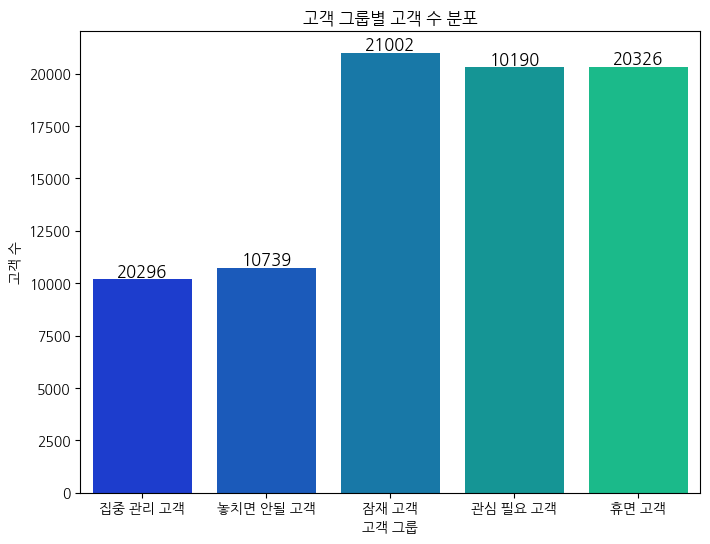

In [42]:
# 고객 그룹 별 고객 수 분포도 확인(등급 순으로)
customer_counts = rfm_nonrepurchase['고객 그룹'].value_counts().sort_index()

# 고객 그룹 별 고객 수 시각화
plt.figure(figsize=(8, 6))
bars = sns.barplot(x=customer_counts.index, y=customer_counts.values, palette='winter', order=['집중 관리 고객', '놓치면 안될 고객', '잠재 고객', '관심 필요 고객', '휴면 고객'])

# 막대 위에 숫자 표시
for bar, count in zip(bars.patches, customer_counts.values):
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_height() + 5  # 숫자를 막대 위에 조금 띄움
    bars.text(text_x, text_y, count, ha='center', va='bottom', fontsize=12)

# 그래프 제목과 축 이름 설정
plt.title('고객 그룹별 고객 수 분포')
plt.xlabel('고객 그룹')
plt.ylabel('고객 수')

plt.show()

# 고객 그룹 별 분석

In [43]:
rfm_nonrepurchase

,고객 고유 ID,recency,Frequency,monetary,recency_log_norm,monetary_log_norm,R_score,M_score,고객 그룹
1,CUSTOMER_Unique_52983,253,1,72.20,0.851925,0.166993,2,2,잠재 고객
2,CUSTOMER_Unique_58227,166,1,28.62,0.787409,0.087009,3,1,잠재 고객
3,CUSTOMER_Unique_59164,385,1,175.26,0.916313,0.244680,1,3,휴면 고객
4,CUSTOMER_Unique_74753,440,1,75.16,0.936807,0.170498,1,2,휴면 고객
5,CUSTOMER_Unique_31015,552,1,35.95,0.971625,0.106557,1,1,휴면 고객
...,...,...,...,...,...,...,...,...,...
85106,CUSTOMER_Unique_52545,508,1,85.08,0.958870,0.181322,1,2,휴면 고객
85107,CUSTOMER_Unique_67637,174,1,195.00,0.794608,0.254065,3,3,관심 필요 고객
85108,CUSTOMER_Unique_17508,336,1,271.01,0.895427,0.283037,1,4,잠재 고객
85109,CUSTOMER_Unique_14906,202,1,1764.64,0.817443,0.448392,3,4,집중 관리 고객


## 고객 그룹 별 총 거래 금액

In [44]:
# 고객 그룹 별 총 거래 금액 확인 및 정렬
total_sales_by_group = rfm_nonrepurchase.groupby('고객 그룹')['monetary'].sum().reset_index()
total_sales_by_group = total_sales_by_group.sort_values(by='monetary', ascending=False)

# 결과 출력
total_sales_by_group

,고객 그룹,monetary
3,집중 관리 고객,13952452.97
1,놓치면 안될 고객,8826779.66
2,잠재 고객,7847827.08
0,관심 필요 고객,1895476.33
4,휴면 고객,1647627.58


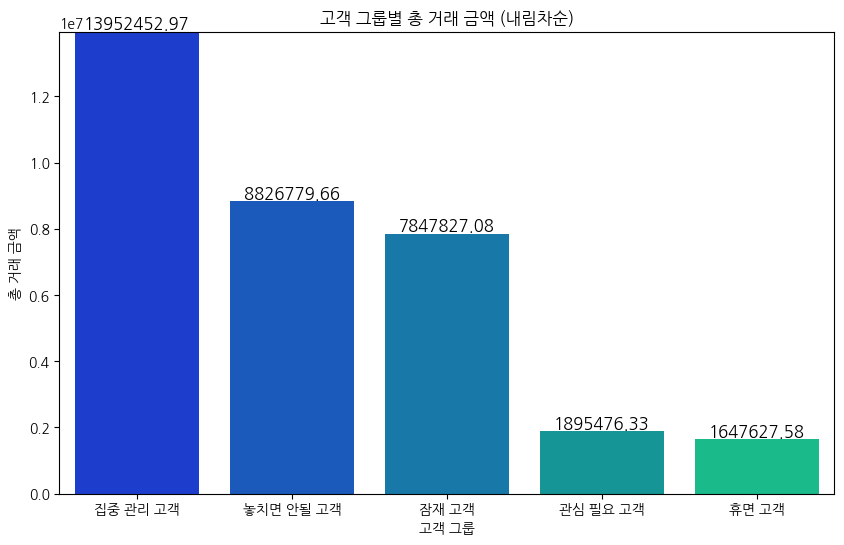

In [45]:
# 고객 그룹 별 총 거래 금액 시각화
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='고객 그룹', y='monetary', data=total_sales_by_group, palette='winter')

# 막대 위에 금액 표시
for bar, amount in zip(bars.patches, total_sales_by_group['monetary']):
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_height() + 0.5  # 숫자를 막대 위에 조금 띄움
    bars.text(text_x, text_y, f'{amount:.2f}', ha='center', va='bottom', fontsize=12)

# 그래프 제목과 축 이름 설정
plt.title('고객 그룹별 총 거래 금액 (내림차순)')
plt.xlabel('고객 그룹')
plt.ylabel('총 거래 금액')
plt.ylim(0, total_sales_by_group['monetary'].max() + 1000)  # y축 범위 설정
plt.show()

## 고객 그룹 별 1인 구매 평균

In [53]:
# 고객 그룹 별 총 거래 금액 및 고객 수 계산
grouped_sales = rfm_nonrepurchase.groupby('고객 그룹')['monetary'].agg(['sum', 'count']).reset_index()
grouped_sales['1인 평균 거래 금액'] = grouped_sales['sum'] / grouped_sales['count']

In [54]:
# 1인 평균 거래 금액을 기준으로 데이터프레임 정렬
sorted_grouped_sales = grouped_sales.sort_values(by='1인 평균 거래 금액', ascending=False)

sorted_grouped_sales

,고객 그룹,sum,count,1인 평균 거래 금액
3,집중 관리 고객,13952452.97,10190,1369.229928
1,놓치면 안될 고객,8826779.66,10739,821.936834
2,잠재 고객,7847827.08,21002,373.670464
0,관심 필요 고객,1895476.33,20296,93.391621
4,휴면 고객,1647627.58,20326,81.060099


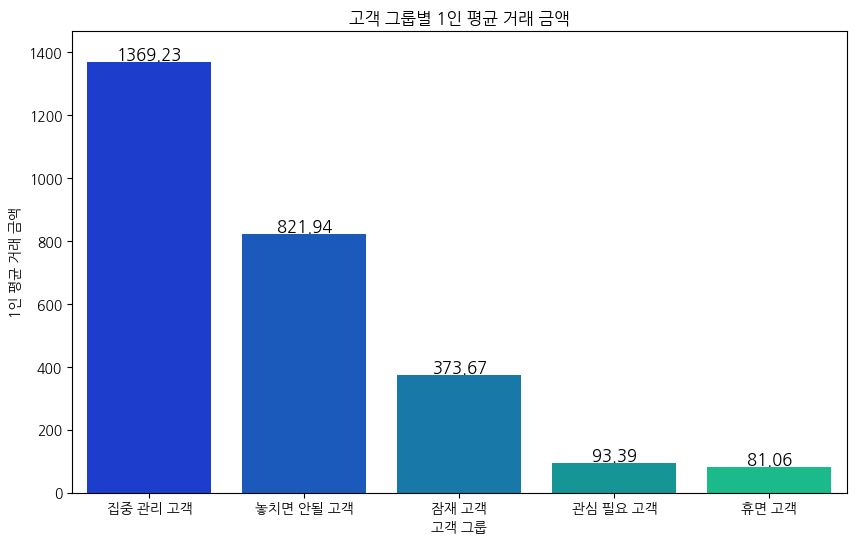

In [55]:
# 고객 그룹 별 1인 평균 거래 금액 시각화
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='고객 그룹', y='1인 평균 거래 금액', data=sorted_grouped_sales, palette='winter')

# 막대 위에 금액 표시
for bar, avg_amount in zip(bars.patches, sorted_grouped_sales['1인 평균 거래 금액']):
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_height() + 0.5  # 숫자를 막대 위에 조금 띄움
    bars.text(text_x, text_y, f'{avg_amount:.2f}', ha='center', va='bottom', fontsize=12)

# 그래프 제목과 축 이름 설정
plt.title('고객 그룹별 1인 평균 거래 금액')
plt.xlabel('고객 그룹')
plt.ylabel('1인 평균 거래 금액')
plt.ylim(0, sorted_grouped_sales['1인 평균 거래 금액'].max() + 100)  # y축 범위 설정
plt.show()

## 고객 그룹 별 매출 비중

In [49]:
# 고객 등급별 매출 비중 계산
total_sales = rfm_nonrepurchase['monetary'].sum()
rfm_df_grouped = rfm_nonrepurchase.groupby('고객 그룹', as_index=False)['monetary'].sum()
rfm_df_grouped['매출 백분율'] = rfm_df_grouped['monetary'] / total_sales * 100

# 매출 백분율을 기준으로 데이터프레임 정렬
rfm_df_grouped = rfm_df_grouped.sort_values(by='매출 백분율', ascending=False)

rfm_df_grouped

,고객 그룹,monetary,매출 백분율
3,집중 관리 고객,13952452.97,40.832269
1,놓치면 안될 고객,8826779.66,25.831833
2,잠재 고객,7847827.08,22.966899
0,관심 필요 고객,1895476.33,5.547168
4,휴면 고객,1647627.58,4.821831


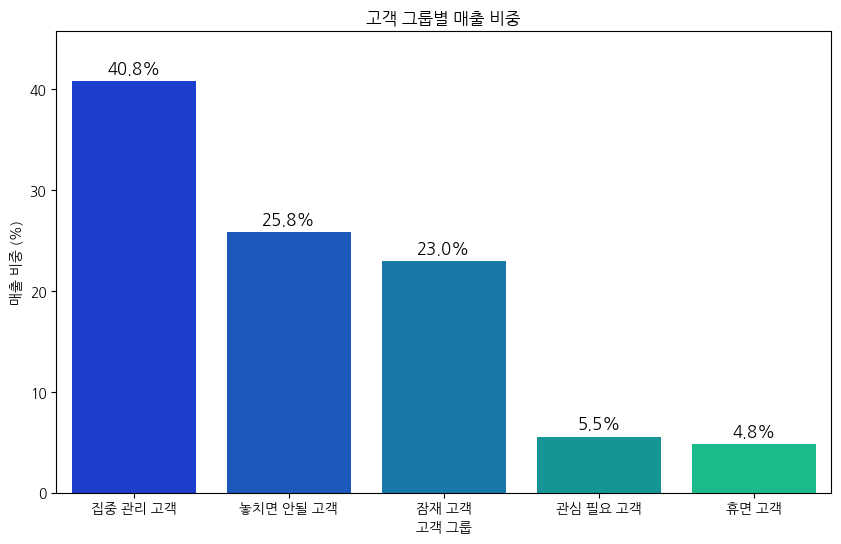

In [50]:
# 고객 등급별 매출 비중 시각화
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=rfm_df_grouped['고객 그룹'], y=rfm_df_grouped['매출 백분율'], palette='winter')

# 막대 위에 비중 표시
for bar, perc in zip(bars.patches, rfm_df_grouped['매출 백분율']):
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_height() + 0.5  # 숫자를 막대 위에 조금 띄움
    bars.text(text_x, text_y, f'{perc:.1f}%', ha='center', va='bottom', fontsize=12)

# 그래프 제목과 축 이름 설정
plt.title('고객 그룹별 매출 비중')
plt.xlabel('고객 그룹')
plt.ylabel('매출 비중 (%)')
plt.ylim(0, rfm_df_grouped['매출 백분율'].max() + 5)  # y축 범위 설정
plt.show()